Trying to make a Time Series RNN

In [1]:
import numpy as np
from io import open
import unicodedata
import string
import re
import random
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import datetime



# I assume cpu for me
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Read the CSV file into a pandas DataFrame
df = pd.read_csv('us.csv', header=None)

# Extract the desired rows
# Step 1: Convert the dates, hospitalizations, and deaths into separate arrays
dates = np.array(df.iloc[:, 0])
hospitalizations = np.array(df.iloc[:, 1])
deaths = np.array(df.iloc[:, 2])


 
# format



c:\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For a nice progress bar!
# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        ## maybe multply and output size 1
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        #Forward prop
        out, _ = self.rnn(x.long(), h0.long())
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        return out
        #output = self.fc(output[:, -1, :])
        #return output

#model = SimpleRNN(3, 10)
#x = torch.randn(64, 3)
#print(model(x).shape)

# Hyperparameters
hidden_size = 256
num_layers = 2
input_size = 3 
learning_rate = 0.001
batch_size =64
num_epochs = 1

# Integer encoding for dates
unique_dates = sorted(list(set(dates)))
date_to_int = {date: i for i, date in enumerate(unique_dates)}
train_dates = np.array([date_to_int[date] for date in dates])

# Prepare the training data
# Prepare the training data


train_dataset = np.column_stack((train_dates, hospitalizations, deaths))
train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True)

## no difference for now, test on future dates
test_dataset = np.column_stack((train_dates, hospitalizations, deaths))
test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=True)
#initialize
model = RNN(input_size = input_size, hidden_size= hidden_size, num_layers = num_layers).to(device)
#loss optim
criterion = nn.MSELoss()
print(model.parameters())
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# Train
# Train
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device=device).long() 
        targets = targets.to(device=device).long()  # Convert targets to LongTensor
        
        # forward
        scores = model(data.unsqueeze(0).long())
        loss = criterion(scores, targets.long())  # Use targets.long()

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# ...


def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f'Got {num_correct} / {num_samples} with accuracy')

    model.train()

check_accuracy(train_loader, model)
check_accuracy(test_loader, model)


c:\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'dates' is not defined

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

# Hyperparameters
hidden_size = 256
num_layers = 2
input_size = 2 
learning_rate = 0.001
batch_size = 64
num_epochs = 1

# Integer encoding for dates
# Integer encoding for dates
unique_dates = sorted(list(set([str(date) for date in dates.numpy()])))
date_to_int = {date: i for i, date in enumerate(unique_dates)}
train_dates = np.array([date_to_int[str(date)] for date in dates.numpy()])

# Prepare the training data

# Prepare the training data
train_dataset = TensorDataset(dates.unsqueeze(1).long(), hospitalizations.float(), deaths.float())
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train
for epoch in range(num_epochs):
    for dates, hospitalizations, deaths in train_loader:
        dates = dates.to(device)
        hospitalizations = hospitalizations.to(device)
        deaths = deaths.to(device)

        inputs = torch.cat((dates, hospitalizations), dim=3)  # Combine dates and hospitalizations
        
        outputs = model(inputs.unsqueeze(0))

        loss = criterion(outputs, deaths.unsqueeze(1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# ...



c:\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'dates' is not defined

In [5]:

def convert_prediction(pred):
    print(pred)
    print(np.std(deaths))
    print(np.mean(deaths))

    pred = pred * np.std(deaths) + np.mean(deaths)
    return pred

def predict_future(date, currentHospitalizations):
    test_date = date_to_int[date]
    test_input = np.array([[test_date, currentHospitalizations]])
    test_input = torch.from_numpy(test_input).float()
    print(test_input)
    with torch.no_grad():
        output = model(test_input.unsqueeze(0))
        predicted_deaths = convert_prediction(output.squeeze().item())
        # predicted_hospitalizations = test_input[0, 1].item() * hospitalizations_std + hospitalizations_mean

    return predicted_deaths

# Usage example: Predict future deaths and hospitalizations for a specific date
#2023-03-06,103382801,1129530
#2023-03-07,103406609,1129852

future_date = '2023-03-07'
currentHospitalization = 1129530
predicted_deaths = predict_future(future_date, currentHospitalization)
print(f'Predicted deaths for {future_date}: {predicted_deaths}')


tensor([[   1141., 1129530.]])


RuntimeError: input.size(-1) must be equal to input_size. Expected 3, got 2

In [4]:


# Define a function to get the future date prediction for deaths and hospitalizations
def predict_future(date, currentHospitalizations):
    test_date = date_to_int[date]
    test_input = np.array([[test_date, currentHospitalizations]])
    test_input = torch.from_numpy(test_input).float()
    print(test_input)
    with torch.no_grad():
        output = model(test_input.unsqueeze(0))
        predicted_deaths = convert_prediction(output.squeeze().item())

        print(test_input[0, 1].item())
        predicted_hospitalizations = test_input[0, 1].item() * hospitalizations_std + hospitalizations_mean

    return predicted_deaths, predicted_hospitalizations

# Usage example: Predict future deaths and hospitalizations for a specific date
#2023-03-06,103382801,1129530
#2023-03-07,103406609,1129852

future_date = '2023-03-07'
currentHospitalization = 103382801
predicted_deaths, predicted_hospitalizations = predict_future(future_date, currentHospitalization)
print(f'Predicted deaths for {future_date}: {predicted_deaths}')
print(f'Predicted hospitalizations for {future_date}: {predicted_hospitalizations}')


tensor([[1.1410e+03, 1.0338e+08]])


RuntimeError: input.size(-1) must be equal to input_size. Expected 3, got 2

In [61]:
# Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters
input_size = 2
hidden_size = 256
num_layers = 5
num_classes = 1
sequence_length = 1
learning_rate = 0.005
batch_size = 1
num_epochs = 3


class CovidDataset(Dataset):
    def __init__(self, dates, hospitalizations, deaths):
        self.dates = dates
        self.hospitalizations = hospitalizations
        self.deaths = deaths

    def __getitem__(self, index):
        date = self.dates[index]
        hospitalization = self.hospitalizations[index]
        death = self.deaths[index]
        return date, hospitalization, death

    def __len__(self):
        return len(self.deaths)


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


# Read the CSV file into a pandas DataFrame
df = pd.read_csv('us.csv', header=None)

# Extract the desired rows
datesOG = np.array(df.iloc[:, 0])
hospitalizationsOG = np.array(df.iloc[:, 1])
deathsOG = np.array(df.iloc[:, 2])
## Normalize

hospitalizations_norm = (hospitalizationsOG - hospitalizationsOG.min()) / (
    hospitalizationsOG.max() - hospitalizationsOG.min()
)
deaths_norm = (deathsOG - deathsOG.min()) / (deathsOG.max() - deathsOG.min())



# Integer encoding for dates
unique_dates = sorted(list(set(datesOG)))
date_to_int = {date: i for i, date in enumerate(unique_dates)}
train_dates = np.array([date_to_int[date] for date in datesOG])

train_dataset = np.column_stack((train_dates, hospitalizations_norm, deaths_norm))
test_dataset = np.column_stack((train_dates, hospitalizations_norm, deaths_norm))

covid_dataset = CovidDataset(train_dates, hospitalizations_norm, deaths_norm)
train_loader = DataLoader(dataset=covid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=covid_dataset, batch_size=batch_size, shuffle=True)

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for batch_idx, (dates, hospitalizations, targets) in enumerate(tqdm(train_loader)):
        targets = targets.float().unsqueeze(1).to(device)
        data = torch.stack((torch.tensor(dates, dtype=torch.float32), torch.tensor(hospitalizations, dtype=torch.float32)), dim=1).to(device).unsqueeze(0)

        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Check accuracy on training & test to see how good our model is
def check_accuracy(loader, model):
    total_loss = 0
    num_samples = 0

    model.eval()
    with torch.no_grad():
        for dates, hospitalizations, targets in loader:
            print(dates)
            targets = targets.float().unsqueeze(1).to(device)
            data = torch.stack((torch.tensor(dates, dtype=torch.float32), torch.tensor(hospitalizations, dtype=torch.float32)), dim=1).to(device).unsqueeze(0)
            # Make prediction
            model.eval()
            prediction = model(data).item()
            print("----------------")
            print(prediction)
            print("----------------")

            # Denormalize prediction
            prediction_denorm = prediction * (deathsOG.max() - deathsOG.min()) + deathsOG.min()
            print("========================")
            print(prediction_denorm)
            print("========================")

            print("***********************")
            print(targets)
            print("***********************")



            scores = model(data)
            loss = criterion(scores, targets)

            total_loss += loss.item() * targets.size(0)
            num_samples += targets.size(0)

    model.train()

    average_loss = total_loss / num_samples
    return average_loss

train_loss = check_accuracy(train_loader, model)
test_loss = check_accuracy(test_loader, model)

	# Denormalize the loss
train_loss_denorm = train_loss * (deathsOG.max() - deathsOG.min()) + deathsOG.min()
test_loss_denorm = test_loss * (deathsOG.max() - deathsOG.min()) + deathsOG.min()

print(f"Loss on training set: {train_loss_denorm:.2f}")
print(f"Loss on test set: {test_loss_denorm:.2f}")


  0%|          | 0/1158 [00:00<?, ?it/s]

C:\Users\eddie\AppData\Local\Temp\ipykernel_30196\4249624971.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.stack((torch.tensor(dates, dtype=torch.float32), torch.tensor(hospitalizations, dtype=torch.float32)), dim=1).to(device).unsqueeze(0)
100%|██████████| 1158/1158 [00:08<00:00, 129.13it/s]
C:\Users\eddie\AppData\Local\Temp\ipykernel_30196\4249624971.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.stack((torch.tensor(dates, dtype=torch.float32), torch.tensor(hospitalizations, dtype=torch.float32)), dim=1).to(device).unsqueeze(0)


tensor([115], dtype=torch.int32)
----------------
0.34505584836006165
----------------
391756.74204465747
***********************
tensor([[0.0771]])
***********************
tensor([914], dtype=torch.int32)
----------------
0.3450559079647064
----------------
391756.8097163737
***********************
tensor([[0.9013]])
***********************
tensor([175], dtype=torch.int32)
----------------
0.34505584836006165
----------------
391756.74204465747
***********************
tensor([[0.1201]])
***********************
tensor([246], dtype=torch.int32)
----------------
0.3450559079647064
----------------
391756.8097163737
***********************
tensor([[0.1778]])
***********************
tensor([556], dtype=torch.int32)
----------------
0.3450559079647064
----------------
391756.8097163737
***********************
tensor([[0.5397]])
***********************
tensor([1124], dtype=torch.int32)
----------------
0.34505587816238403
----------------
391756.7758805156
***********************
tensor([[0.

In [58]:
def predict_death(model, date, hospitalization):
    # Normalize input
    hospitalization_norm = (hospitalization - hospitalizationsOG.min()) / (
        hospitalizationsOG.max() - hospitalizationsOG.min()
    )

    # Prepare input tensor
    input_data = torch.tensor([[date, hospitalization_norm]], dtype=torch.float32).to(device).unsqueeze(0)

    # Make prediction
    model.eval()
    with torch.no_grad():
        prediction = model(input_data).item()

    # Denormalize prediction
    prediction_denorm = prediction * (deathsOG.max() - deathsOG.min()) + deathsOG.min()

    return prediction_denorm

# Assuming the model is already trained and initialized as `model`

# Sample input
sample_date = 20  # Example date value
sample_hospitalization = 5000  # Example hospitalization value

# Predict deaths
predicted_deaths = predict_death(model, sample_date, sample_hospitalization)

print(f"Predicted deaths: {predicted_deaths}")



Predicted deaths: -32577.54483845085


## Founding a more complicated one from a super simple

In [44]:
# Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch
import torch.nn as nn

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Set the hyperparameters
input_size = 3  # Number of features (dates, hospitalizations and deaths)
hidden_size = 64
output_size = 1 # Number of predicted features (deaths)
num_epochs = 1000
learning_rate = 0.001

# Create an instance of the RNN model
model = RNN(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define the training loop
def train(model, data, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        inputs = torch.Tensor(data[:-1]).unsqueeze(0)  # Input sequences
        targets = torch.Tensor(data[1:])  # Target sequences

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print the loss every 10 epochs
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Example usage
#data = [
 #   [10, 2],  # Hospitalizations and deaths for day 1
#    [15, 3],  # Hospitalizations and deaths for day 2
#    [12, 1],  # Hospitalizations and deaths for day 3
    # Add more historical data here#
#]
#
hospitalizations_small = [10, 15, 20, 30, 40, 50, 60, 70, 80, 90]
deaths_small = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
dates_small = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
data = np.column_stack((dates_small, hospitalizations_small, deaths_small))
#print(data)
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('us.csv', header=None)

# Extract the desired rows
datesOG = np.array(df.iloc[:, 0])
hospitalizations = np.array(df.iloc[:, 1])
deaths = np.array(df.iloc[:, 2])

## Normalize
hospitalizations_norm = (hospitalizationsOG - hospitalizationsOG.min()) / (
    hospitalizationsOG.max() - hospitalizationsOG.min()
)
deaths_norm = (deathsOG - deathsOG.min()) / (deathsOG.max() - deathsOG.min())
# Integer encoding for dates

unique_dates = sorted(list(set(datesOG)))
date_to_int = {date: i for i, date in enumerate(unique_dates)}
train_dates = np.array([date_to_int[date] for date in datesOG])

datalp = np.column_stack((hospitalizations, deaths))

#print(train_dataset)


train(model, data, num_epochs)

# Predict the hospitalizations and deaths for a certain date
input_data = torch.Tensor([[1]]).unsqueeze(0)  # Hospitalizations and deaths for the given date
predicted_data = model(input_data)
print("Predicted deaths:", predicted_data.tolist())


RuntimeError: input must have 3 dimensions, got 2

In [48]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

# number of points
num_time_steps = 50
hidden_size = 10
input_size = 1
output_size = 1
lr = 0.01


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            # use batch_first for input with another data shape with b first
        )
        # compress output to the same dim as y
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_prev):
        out, hidden_prev = self.rnn(x, hidden_prev)
        # [1, seq, h] => [seq, h]  (batch=1)
        out = out.reshape(-1, hidden_size)  # stack batch and seq

        # linear layer so that output is not [seq,h] but [seq, 1]
        # so it is comparable with y, for loss calculation
        out = self.linear(out)  # [seq, h] => [seq, 1]
        out = out.unsqueeze(dim=0)  # => [1, seq, 1]
        return out, hidden_prev



model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

hidden_prev = torch.zeros(1, 1, hidden_size)  # [b, layer, mem_size]

for iter in range(6000):
    # randomly generate start point from 0 to 2
    start = np.random.randint(3, size=1)[0]
    # eg. from 0 to 10, create 50 points in between
    time_steps = np.linspace(start, start + 10, num_time_steps)
    data = np.sin(time_steps)
    data = data.reshape(num_time_steps, 1)
    # x: 49 points 0-49; y: 49 points 1-50
    x = torch.tensor(data[:-1]).float().reshape(1, num_time_steps - 1, 1)  # [b, seq_len, fea_len]
    y = torch.tensor(data[1:]).float().reshape(1, num_time_steps - 1, 1)  # [b, seq_len, fea_len]

    output, hidden_prev = model(x, hidden_prev)
    hidden_prev = hidden_prev.detach()

    # print(f"output {output.shape}, y {y.shape}")
    loss = criterion(output, y)
    model.zero_grad()
    # optimizer.zero_grad()
    # both zero_grad() are the same if model.parameters() is feed to the same optimizer
    # only matters if multiple models using same optimizer or multiple optims used for a model
    loss.backward()
    optimizer.step()

    if iter % 100 == 0:
       print(f"iteration: {iter}, loss {loss.item()}")

start = np.random.randint(3, size=1)[0]
time_steps = np.linspace(start, start+10, num_time_steps)
data = np.sin(time_steps)
data = data.reshape(num_time_steps, 1)
x = torch.tensor(data[:-1]).float().reshape(1, num_time_steps-1, 1)

preds = []
input_x = x[:, 0, :]  # select first point
for _ in range(x.shape[1]):
    input_x = input_x.reshape(1, 1, 1)  # reshape it for model feeding
    pred, hidden_prev = model(input_x, hidden_prev)
    # print(pred.shape)
    # print(hidden_prev.shape)
    input_x = pred
    preds.append(pred.detach().numpy().ravel()[0])

x = x.data.numpy().ravel()
plt.scatter(time_steps[:-1], x.ravel(), s=10, label='original')
plt.plot(time_steps[:-1], x.ravel())

plt.scatter(time_steps[1:], preds, label='predicted')
plt.legend()
plt.show()

TypeError: forward() missing 1 required positional argument: 'hidden_prev'

In [5]:
# Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch
import torch.nn as nn

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Set the hyperparameters
input_size = 2  # Number of features (dates, hospitalizations and deaths)
hidden_size = 64
output_size = 1 # Number of predicted features (deaths)
num_epochs = 1000
learning_rate = 0.001

# Create an instance of the RNN model
model = RNN(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Define the training loop
def train(model, data, num_epochs, target):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)

        # Compute the loss
        loss = criterion(outputs, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print the loss at certain intervals
        if (epoch+1) % 100 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')


hospitalizations_small = [10, 15, 20, 30, 40, 50, 60, 70, 80, 90]
deaths_small = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
dates_small = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
data = np.column_stack((dates_small, hospitalizations_small))
data = torch.Tensor(data) # Input sequences

# Assuming you have a list of target values for deaths
target_values = [10, 15, 20, 8, 12]

# Convert the target values to a PyTorch tensor
target_tensor = torch.tensor(target_values, dtype=torch.float32)
target_tensor = target_tensor.view(-1, output_size)

train(model, data, num_epochs, target_tensor)




RuntimeError: input must have 3 dimensions, got 2

Epoch 10/100, Loss: 0.126456618309021
Epoch 20/100, Loss: 0.08516836166381836
Epoch 30/100, Loss: 0.018220599740743637
Epoch 40/100, Loss: 0.015615582466125488
Epoch 50/100, Loss: 0.012586679309606552
Epoch 60/100, Loss: 0.0078033218160271645
Epoch 70/100, Loss: 0.0058565945364534855
Epoch 80/100, Loss: 0.004834135994315147
Epoch 90/100, Loss: 0.0041308836080133915
Epoch 100/100, Loss: 0.0036690605338662863
tensor([[1.4277, 1.2242]])
tensor([[1.4088, 1.2140]])
tensor([[1.3900, 1.2056]])
tensor([[1.3650, 1.1901]])
tensor([[1.3455, 1.1699]])
tensor([[1.3115, 1.1591]])
tensor([[1.2781, 1.1440]])
tensor([[1.2522, 1.1299]])
tensor([[1.2522, 1.1299]])
tensor([[1.2522, 1.1299]])
tensor([[1.2522, 1.1299]])
tensor([[1.2522, 1.1299]])
tensor([[1.2522, 1.1299]])
tensor([[1.2522, 1.1299]])
tensor([[1.2522, 1.1299]])
tensor([[1.2522, 1.1299]])
tensor([[1.2522, 1.1299]])
tensor([[1.2522, 1.1299]])
tensor([[1.2522, 1.1299]])
tensor([[1.2522, 1.1299]])
tensor([[1.2522, 1.1299]])
tensor([[1.2522, 1.129

TypeError: list indices must be integers or slices, not tuple

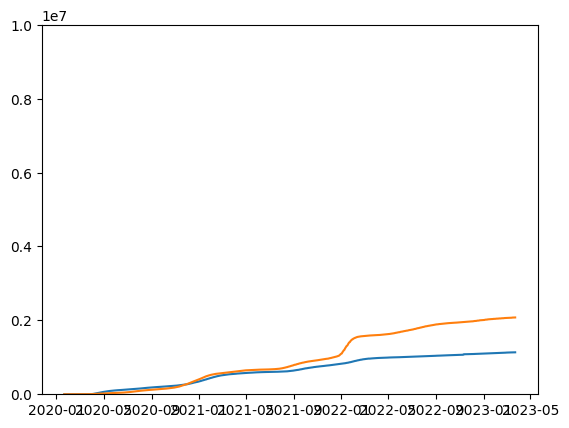

In [31]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data is stored in a CSV file, you can load it into a pandas DataFrame
data = pd.read_csv("us.csv", header=None, names=["Date", "Hospitalization", "Death"])

# Convert the "Date" column to a pandas DateTime object
data["Date"] = pd.to_datetime(data["Date"])

# Sort the data by date if it's not already sorted
data.sort_values("Date", inplace=True)

# Extract the values as numpy arrays
Hospitalization = data["Hospitalization"].values.astype(float)
Death = data["Death"].values.astype(float)

# Normalize the data
normalized_Hospitalization = (Hospitalization - np.mean(Hospitalization)) / np.std(Hospitalization)
normalized_Death = (Death - np.mean(Death)) / np.std(Death)

# Define the sequence length and number of features
sequence_length = 7  # Number of previous days to consider
num_features = 2  # Number of input features (Value1 and Value2)

# Create input sequences and corresponding targets
input_sequences = []
targets = []

## all input - 7 last days
for i in range(len(normalized_Hospitalization) - sequence_length):
    seq = np.array([normalized_Hospitalization[i:i+sequence_length], normalized_Death[i:i+sequence_length]])
    input_sequences.append(seq)
    targets.append([normalized_Hospitalization[i+sequence_length], normalized_Death[i+sequence_length]])

# Convert the input sequences and targets to PyTorch tensors
input_sequences = torch.tensor(input_sequences).float()
targets = torch.tensor(targets).float()

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0[:, :x.size(0), :])
        out = self.fc(out[:, -1, :])
        return out

# Define the hyperparameters
input_size = sequence_length
hidden_size = 64
num_layers = 2
output_size = num_features

# Create an instance of the RNN model
model = RNN(input_size, hidden_size, num_layers, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the input sequences and targets to the device
input_sequences = input_sequences.to(device)
targets = targets.to(device)

# Move the model to the device
model = model.to(device)

# Set the number of training epochs
num_epochs = 100

# Training loop
for epoch in range(num_epochs):
    model.train()
    outputs = model(input_sequences)
    loss = criterion(outputs, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Switch the model to evaluation mode
# Switch the model to evaluation mode
model.eval()

# Generate predictions
with torch.no_grad():
    future_sequence = input_sequences[-1].unsqueeze(0)  # Use the last input sequence as the initial future sequence
    future_sequence = future_sequence.to(device)

    predicted_values = []

    for _ in range(300):  # Generate 30 days of future predictions
        hospitalizations =  model(future_sequence)
        print(hospitalizations)
        predicted_values.append(future_prediction)
                # Update the future sequence by removing the first input and appending the new prediction
        future_sequence = torch.cat((future_sequence[:, :, 1:], future_prediction.unsqueeze(2)), dim=2)


print(predicted_values)


# Denormalize the predicted values
#predicted_values = np.array(predicted_values)
#predicted_values[:, 0] = (predicted_values[:, 0] * np.std(Hospitalization)) + np.mean(Hospitalization)
#predicted_values[:, 1] = (predicted_values[:, 0] * np.std(Death)) + np.mean(Death)

# Generate dates for the future predictions
dates = pd.date_range(start=data["Date"].iloc[-1], periods=300)

# Plot the actual values and predicted values
plt.plot(data["Date"], data["Death"], label="Actual Death")
# Adjust the y-axis scale

plt.plot(data["Date"], (data["Hospitalization"] / 50), label="Actual Hospitalization")
#print(data["Hospitalization"])
plt.ylim(0, 10000000)  # Set the minimum and maximum values for the y-axis
plt.plot(dates, (predicted_values[:, 0] / 50), label="Predicted Hospitalization")
plt.plot(dates, (predicted_values[:, 1] / 50), label="Predicted Death")
#plt.xlabel("Date")
#plt.ylabel("Counts")
plt.legend()
plt.show()


Epoch 10/1000, Loss: 0.10092370957136154
Epoch 20/1000, Loss: 0.03994571790099144
Epoch 30/1000, Loss: 0.01933804154396057
Epoch 40/1000, Loss: 0.012987358495593071
Epoch 50/1000, Loss: 0.009922192431986332
Epoch 60/1000, Loss: 0.007918041199445724
Epoch 70/1000, Loss: 0.006507321260869503
Epoch 80/1000, Loss: 0.0054055009968578815
Epoch 90/1000, Loss: 0.0046128337271511555
Epoch 100/1000, Loss: 0.004051609430462122
Epoch 110/1000, Loss: 0.0036002080887556076
Epoch 120/1000, Loss: 0.0032392486464232206
Epoch 130/1000, Loss: 0.00293922726996243
Epoch 140/1000, Loss: 0.0026835226453840733
Epoch 150/1000, Loss: 0.0024613775312900543
Epoch 160/1000, Loss: 0.002265040297061205
Epoch 170/1000, Loss: 0.0020890694577246904
Epoch 180/1000, Loss: 0.0019295427482575178
Epoch 190/1000, Loss: 0.0017836085753515363
Epoch 200/1000, Loss: 0.0016491423593834043
Epoch 210/1000, Loss: 0.0015245373360812664
Epoch 220/1000, Loss: 0.0014085606671869755
Epoch 230/1000, Loss: 0.001300258096307516
Epoch 240/10

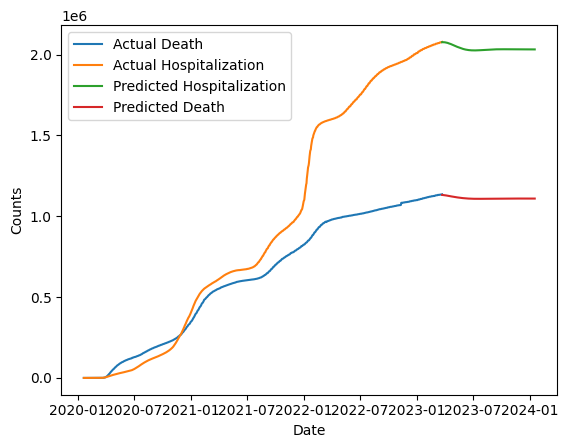

In [40]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data is stored in a CSV file, you can load it into a pandas DataFrame
data = pd.read_csv("us.csv", header=None, names=["Date", "Hospitalization", "Death"])

# Convert the "Date" column to a pandas DateTime object
data["Date"] = pd.to_datetime(data["Date"])

# Sort the data by date if it's not already sorted
data.sort_values("Date", inplace=True)

# Extract the values as numpy arrays
Hospitalization = data["Hospitalization"].values.astype(float)
Death = data["Death"].values.astype(float)

# Normalize the data
normalized_Hospitalization = (Hospitalization - np.mean(Hospitalization)) / np.std(Hospitalization)
normalized_Death = (Death - np.mean(Death)) / np.std(Death)

# Define the sequence length and number of features
sequence_length = 30  # Number of previous days to consider
num_features = 2  # Number of input features (Value1 and Value2)

# Create input sequences and corresponding targets
input_sequences = []
targets = []

## all input - 7 last days
for i in range(len(normalized_Hospitalization) - sequence_length):
    seq = np.array([normalized_Hospitalization[i:i+sequence_length], normalized_Death[i:i+sequence_length]])
    input_sequences.append(seq)
    targets.append([normalized_Hospitalization[i+sequence_length], normalized_Death[i+sequence_length]])

# Convert the input sequences and targets to PyTorch tensors
input_sequences = torch.tensor(input_sequences).float()
targets = torch.tensor(targets).float()

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0[:, :x.size(0), :])
        out = self.fc(out[:, -1, :])
        return out

# Define the hyperparameters
input_size = sequence_length
hidden_size = 64
num_layers = 2
output_size = num_features

# Create an instance of the RNN model
model = RNN(input_size, hidden_size, num_layers, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the input sequences and targets to the device
input_sequences = input_sequences.to(device)
targets = targets.to(device)

# Move the model to the device
model = model.to(device)

# ... previous code ...

# Set the number of training epochs
num_epochs = 1000

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the input sequences and targets to the device
input_sequences = input_sequences.to(device)
targets = targets.to(device)

# Move the model to the device
model = model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    outputs = model(input_sequences)
    loss = criterion(outputs, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Switch the model to evaluation mode
model.eval()

# ... previous code ...

# Generate predictions
with torch.no_grad():
    future_sequence = input_sequences[-1].unsqueeze(0)  # Use the last input sequence as the initial future sequence
    future_sequence = future_sequence.to(device)

    predicted_values = []

    for _ in range(300):  # Generate 30 days of future predictions
        predictions = model(future_sequence)
        predicted_values.append(predictions.squeeze().tolist())

        # Update the future sequence by removing the first input and appending the new predictions
        new_predictions = torch.tensor([predicted_values[-1]]).unsqueeze(0).to(device)
        future_sequence = torch.cat((future_sequence[:, :, 1:], new_predictions.transpose(1, 2)), dim=2)

# Denormalize the predicted values
predicted_values = np.array(predicted_values)
predicted_values[:, 0] = (predicted_values[:, 0] * np.std(Hospitalization)) + np.mean(Hospitalization)
predicted_values[:, 1] = (predicted_values[:, 1] * np.std(Death)) + np.mean(Death)

# Generate dates for the future predictions
dates = pd.date_range(start=data["Date"].iloc[-1], periods=300)

# Plot the actual values and predicted values
plt.plot(data["Date"], data["Death"], label="Actual Death")
plt.plot(data["Date"], (data["Hospitalization"] / 50), label="Actual Hospitalization")
plt.plot(dates, (predicted_values[:, 0] / 50), label="Predicted Hospitalization")
plt.plot(dates, predicted_values[:, 1], label="Predicted Death")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()
plt.show()

